# Z-Scored Comp vs Non-Comp

### Make a dictionary from `combined_excel_file` which is just the cohort2 and cohort3 excel files merged

In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import spikeanal as spike

cols = ['condition', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp', 'competition_closeness']

comp_closeness_dict = {'Subj 1 blocking Subj 2': "competitive",
'Subj 2 Only': "no_comp",
'Subj 2 blocking Subj 1': "competitive",
'Subj 1 then Subj 2': "competitive", 
'Subj 1 Only': "no_comp",
'Subj 2 then Subj 1': "competitive",
'Close Call': "competitive",
'After trial': "no_comp"}

# Load the data
df = pd.read_excel('combined_excel_file.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition']
    compness = row['competition_closeness']
    comp_label = comp_closeness_dict.get(compness, "")  # Default to "" if not found

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"

        # Determine the new condition based on competition and win/lose logic
        if condition in ['rewarded', 'omission', 'both_rewarded', 'tie']:
            new_condition = condition
        else:
            win_or_lose = 'win' if str(condition) == str(subject) else 'lose'
            new_condition = f"{comp_label}_{win_or_lose}"

        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': new_condition,
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
valid_conditions = ['rewarded', 'omission', 'both_rewarded', 'tie', 'no_comp_win', 'no_comp_lose', 'competitive_win', 'competitive_lose']
timestamp_dicts = {}

for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in valid_conditions}
    if condition in valid_conditions:
        timestamp_dicts[key][condition].append(tuple_val)
    else:
        print(f"Unexpected condition: {condition} for subj_recording {key}")

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)

### Import the ephys data

In [2]:
# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'recordings' / 'from_cyborg'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230613_105657_standard_comp_to_training_D2_subj_1-1_t1b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230613_105657_standard_comp_to_training_D2_subj_1-4_t4b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230614_114041_standard_comp_to_training_D3_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230614_114041_standard_comp_to_training_D3_subj_1-2_t2b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230616_111904_standard_comp_to_training_D4_subj_1-2_t2b2L_box2_merged.rec
<class '

### Assign the dictionary to the ephys data and create the SpikeAnalysis_MultiRecording object

In [32]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 250, ignore_freq = 0.5)

All set to analyze


In [33]:
event_and_pre_event_spikes_df = spike_analysis.generate_event_dataframe()

### This is 1 row for each unit for every occurrence of every event

In [34]:
event_and_pre_event_spikes_df

,Recording,Event name,Event number,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,...,Event timebin 31,Event timebin 32,Event timebin 33,Event timebin 34,Event timebin 35,Event timebin 36,Event timebin 37,Event timebin 38,Event timebin 39,Event timebin 40
0,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,1,65,12.0,8.0,8.0,8.0,8.0,8.0,...,16.0,4.0,4.0,0.0,8.0,8.0,4.0,4.0,8.0,4.0
1,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,2,65,0.0,0.0,4.0,0.0,4.0,0.0,...,4.0,4.0,8.0,4.0,16.0,4.0,8.0,0.0,8.0,0.0
2,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,3,65,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,4,65,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0
4,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,5,65,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,8.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10023,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,competitive_lose,3,24,12.0,8.0,8.0,12.0,12.0,20.0,...,8.0,12.0,8.0,0.0,8.0,4.0,0.0,8.0,8.0,4.0
10024,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,competitive_lose,4,24,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,4.0,8.0,4.0,4.0,4.0,0.0,0.0,4.0,4.0
10025,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,competitive_lose,5,24,4.0,4.0,12.0,0.0,4.0,4.0,...,12.0,16.0,8.0,12.0,8.0,16.0,4.0,8.0,8.0,12.0
10026,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,competitive_lose,6,24,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,4.0,4.0,0.0,8.0,4.0,4.0,4.0,0.0,8.0


### Average all the occurrences within a recording of each event into just 1 row for each unit

In [35]:
# Assuming event_and_pre_event_spikes_df is already loaded
# Identify the columns to be averaged (all columns starting with 'Pre-event timebin' and 'Event timebin')
timebin_columns = [col for col in event_and_pre_event_spikes_df.columns if 'Pre-event timebin' in col or 'Event timebin' in col]

# Group by 'Recording', 'Event name', 'Unit number' and compute the mean for the timebin columns
event_pre_event_mean_fr = event_and_pre_event_spikes_df.groupby(['Recording', 'Event name', 'Unit number'])[timebin_columns].mean().reset_index()

# Display the new DataFrame
event_pre_event_mean_fr

,Recording,Event name,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,Pre-event timebin 7,...,Event timebin 31,Event timebin 32,Event timebin 33,Event timebin 34,Event timebin 35,Event timebin 36,Event timebin 37,Event timebin 38,Event timebin 39,Event timebin 40
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,0.0,4.0,4.0,4.0,4.0,4.0,0.0,...,4.0,0.0,4.0,12.0,8.0,4.0,8.0,0.0,0.0,8.0
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,8.0,0.0
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.0,0.0,12.0,4.0,4.0,8.0,12.0,...,4.0,4.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.0,10.0,14.0,6.0,8.0,10.0,10.0,...,6.0,10.0,8.0,10.0,6.0,6.0,16.0,12.0,10.0,4.0
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,4.0,6.0,10.0,14.0,24.0,12.0,6.0,...,2.0,2.0,4.0,0.0,2.0,10.0,12.0,4.0,8.0,18.0
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.0,0.0,4.0,8.0,2.0,4.0,10.0,...,4.0,0.0,2.0,0.0,2.0,4.0,8.0,4.0,10.0,8.0
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,4.0,4.0,6.0,4.0,2.0,2.0,6.0,4.0,2.0


In [ ]:
event_cols = [col for col in event_pre_event_mean_fr.columns if 'Event timebin' in col]

# Group by 'Recording', 'Event name', 'Unit number' and compute the mean for the timebin columns
event_pre_event_mean_fr['Event Mean'] = event_pre_event_mean_fr[event_cols].mean(axis=1)

In [ ]:
event_pre_event_mean_fr

### Get the M & SD of the averaged pre-event row, then get the z-score of the average event firing rate based on the pre-event M & SD

In [36]:
# Identify the columns to be averaged (all columns starting with 'Pre-event timebin' and 'Event timebin')
pre_event_columns = [col for col in event_and_pre_event_spikes_df.columns if 'Pre-event timebin' in col]
event_columns = [col for col in event_and_pre_event_spikes_df.columns if 'Event timebin' in col]

# Group by 'Recording', 'Event name', 'Unit number' and compute the required statistics
grouped_df = event_and_pre_event_spikes_df.groupby(['Recording', 'Event name', 'Unit number'])

# Calculate the mean and standard deviation for Pre-event timebin columns
pre_event_means = grouped_df[pre_event_columns].mean().mean(axis=1)
pre_event_sds = grouped_df[pre_event_columns].mean().std(axis=1)

# Calculate the mean for Event timebin columns
event_means = grouped_df[event_columns].mean().mean(axis=1)

# Calculate the Z-score for the Event mean
z_scores = (event_means - pre_event_means) / pre_event_sds

# Create the new DataFrame with the required columns
event_zscores_df = pd.DataFrame({
    'Recording': pre_event_means.index.get_level_values('Recording'),
    'Event name': pre_event_means.index.get_level_values('Event name'),
    'Unit number': pre_event_means.index.get_level_values('Unit number'),
    'Pre-event M': pre_event_means.values,
    'Pre-event SD': pre_event_sds.values,
    'Event M': event_means.values,
    'Event Z-Score': z_scores.values
})

# Reset the index to have a clean DataFrame
event_zscores_df.reset_index(drop=True, inplace=True)

# Display the new DataFrame
event_zscores_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.00,0.000000,0.20,inf
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.30,1.066987,0.50,0.187444
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,4.10,4.482444,4.80,0.156165
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,0.10,0.632456,0.60,0.790569
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.70,3.936678,3.10,-0.406434
...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.15,3.400980,8.35,0.058807
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,6.00,5.528481,3.35,-0.479336
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.00,3.004270,3.35,-0.216359
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.10,0.441443,1.30,2.718359


### ^ 1,746 Event-Units

### Using a significance cutoff score for a 99% 2-tailed confidence interval to determine if the neuron increased firing rate
### Using a significance cutoff score for a 95% 2-tailed confidence interval to determine if the neuron decreased firing rate
These values were suggested to Nancy by Fabricio Do Monte

In [37]:
# Define the conditions and corresponding values
conditions = [
    (event_zscores_df['Event Z-Score'] > 2.58),
    (event_zscores_df['Event Z-Score'] < -1.96)]

values = ['increase', 'decrease']

# Apply the conditions
event_zscores_df['sig'] = np.select(conditions, values, default='not sig')

# Display the new DataFrame
event_zscores_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.00,0.000000,0.20,inf,increase
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.30,1.066987,0.50,0.187444,not sig
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,4.10,4.482444,4.80,0.156165,not sig
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,0.10,0.632456,0.60,0.790569,not sig
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.70,3.936678,3.10,-0.406434,not sig
...,...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.15,3.400980,8.35,0.058807,not sig
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,6.00,5.528481,3.35,-0.479336,not sig
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.00,3.004270,3.35,-0.216359,not sig
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.10,0.441443,1.30,2.718359,increase


In [38]:
event_zscores_df['sig'].value_counts()

sig
not sig     1704
increase      37
decrease       5
Name: count, dtype: int64

In [41]:
(37+5) / (1704+37+5)

0.024054982817869417

### Those cutoffs provided shockingly few significant units (2.4%) so using a 1-tailed 95% confidence interval cutoff for both

In [39]:
# Define the conditions and corresponding values
conditions = [
    (event_zscores_df['Event Z-Score'] > 1.65),
    (event_zscores_df['Event Z-Score'] < -1.65)]

values = ['increase', 'decrease']

# Apply the conditions
event_zscores_df['sig'] = np.select(conditions, values, default='not sig')

# Display the new DataFrame
event_zscores_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.00,0.000000,0.20,inf,increase
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.30,1.066987,0.50,0.187444,not sig
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,4.10,4.482444,4.80,0.156165,not sig
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,0.10,0.632456,0.60,0.790569,not sig
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.70,3.936678,3.10,-0.406434,not sig
...,...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.15,3.400980,8.35,0.058807,not sig
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,6.00,5.528481,3.35,-0.479336,not sig
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.00,3.004270,3.35,-0.216359,not sig
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.10,0.441443,1.30,2.718359,increase


In [40]:
event_zscores_df['sig'].value_counts()

sig
not sig     1665
increase      73
decrease       8
Name: count, dtype: int64

In [42]:
(73+8) / (1665+73+8)

0.04639175257731959

### 4.6% is better

### Import the putative unit types

In [43]:
# Load the umap_df_detail.pkl file
umap_df_detail = pd.read_pickle('Newest_UMAP/umap_df_detail.pkl')

# Merge event_zscores_df with umap_df_detail based on 'Recording' and 'Unit number'
merged_df = event_zscores_df.merge(
    umap_df_detail[['recording_name', 'unit_id', 'cluster_id']],  # Only select necessary columns
    how='left',
    left_on=['Recording', 'Unit number'],
    right_on=['recording_name', 'unit_id']
)

# Create the 'putative type' column based on the 'cluster_id'
merged_df['putative type'] = merged_df['cluster_id'].apply(lambda x: 'interneuron' if x == 5 else 'pyramidal')

# Drop the unnecessary columns
merged_df = merged_df.drop(columns=['recording_name', 'unit_id', 'cluster_id'])

merged_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig,putative type
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.00,0.000000,0.20,inf,increase,pyramidal
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.30,1.066987,0.50,0.187444,not sig,pyramidal
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,4.10,4.482444,4.80,0.156165,not sig,interneuron
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,0.10,0.632456,0.60,0.790569,not sig,pyramidal
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.70,3.936678,3.10,-0.406434,not sig,pyramidal
...,...,...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.15,3.400980,8.35,0.058807,not sig,pyramidal
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,6.00,5.528481,3.35,-0.479336,not sig,pyramidal
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.00,3.004270,3.35,-0.216359,not sig,pyramidal
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.10,0.441443,1.30,2.718359,increase,pyramidal


### To look at only the significant units:

In [44]:
sig_units = merged_df[merged_df['sig'] != 'not sig']

In [45]:
sig_units

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig,putative type
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.000000,0.000000,0.200000,inf,increase,pyramidal
5,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,24,1.500000,2.511512,5.900000,1.751933,increase,pyramidal
14,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,58,0.000000,0.000000,0.200000,inf,increase,pyramidal
33,20230612_101430_standard_comp_to_training_D1_s...,competitive_win,54,0.662500,0.592555,1.975000,2.214983,increase,pyramidal
74,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,53,0.000000,0.000000,0.020000,inf,increase,pyramidal
...,...,...,...,...,...,...,...,...,...
1700,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,competitive_lose,75,0.114286,0.265197,0.885714,2.908884,increase,pyramidal
1727,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,no_comp_win,24,0.700000,1.168923,10.400000,8.298235,increase,interneuron
1735,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,0,1.150000,1.747526,5.100000,2.260339,increase,pyramidal
1738,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,24,0.650000,1.311683,5.900000,4.002491,increase,interneuron


In [46]:
# sig_units.to_csv('compness_units_types.csv')

In [50]:
pre_event_sd = event_zscores_df['Pre-event SD'].value_counts()

In [51]:
pre_event_sd

Pre-event SD
0.000000    21
1.066987    11
0.882886    10
0.632456     9
1.215287     7
            ..
2.365709     1
2.746663     1
6.756236     1
3.111416     1
2.145425     1
Name: count, Length: 1535, dtype: int64

It looked like there might be a lot of units w/ a 0 SD which causes division by 0 for z-scoring, but it was only 21 out of 1,746

### Convert the 1,746 Event-Units to actual Units by only having 1 row per unit

In [52]:
# Group by 'Recording' and 'Unit number' and aggregate the required columns
grouped = merged_df.groupby(['Recording', 'Unit number']).agg({
    'Event name': lambda x: list(x),
    'sig': lambda x: list(x),
    'putative type': 'first'  # Assuming 'putative type' is consistent within each group
}).reset_index()

# Initialize lists to store the 'sig events' and 'not sig events'
sig_events = []
not_sig_events = []

# Iterate over the grouped DataFrame to populate the lists
for index, row in grouped.iterrows():
    sig_list = []
    not_sig_list = []
    for event_name, sig in zip(row['Event name'], row['sig']):
        if sig != 'not sig':
            sig_list.append(event_name)
        else:
            not_sig_list.append(event_name)
    sig_events.append(sig_list)
    not_sig_events.append(not_sig_list)

# Create the final DataFrame
units_df = pd.DataFrame({
    'Recording': grouped['Recording'],
    'Unit number': grouped['Unit number'],
    'sig events': sig_events,
    'not sig events': not_sig_events,
    'putative type': grouped['putative type']
})

# Display the new DataFrame
units_df

,Recording,Unit number,sig events,not sig events,putative type
0,20230612_101430_standard_comp_to_training_D1_s...,5,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal
1,20230612_101430_standard_comp_to_training_D1_s...,10,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
2,20230612_101430_standard_comp_to_training_D1_s...,13,[],"[competitive_lose, competitive_win, no_comp_lo...",interneuron
3,20230612_101430_standard_comp_to_training_D1_s...,17,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
4,20230612_101430_standard_comp_to_training_D1_s...,19,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
...,...,...,...,...,...
497,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,49,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
498,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,54,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
499,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,68,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
500,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,75,"[competitive_lose, tie]","[competitive_win, no_comp_lose, no_comp_win]",pyramidal


### To only look at significant units again:

In [94]:
# Filter the units_df to include only rows where 'sig events' is not an empty list
sig_units2 = units_df[units_df['sig events'].apply(lambda x: len(x) > 0)].copy()

In [95]:
sig_units2

,Recording,Unit number,sig events,not sig events,putative type
0,20230612_101430_standard_comp_to_training_D1_s...,5,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal
5,20230612_101430_standard_comp_to_training_D1_s...,24,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal
11,20230612_101430_standard_comp_to_training_D1_s...,53,[no_comp_win],"[competitive_lose, competitive_win, no_comp_lose]",pyramidal
12,20230612_101430_standard_comp_to_training_D1_s...,54,[competitive_win],"[competitive_lose, no_comp_lose, no_comp_win]",pyramidal
14,20230612_101430_standard_comp_to_training_D1_s...,58,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal
...,...,...,...,...,...
487,20240323_144517_alone_comp_subj_3-4_t6b6_merge...,4,"[competitive_win, no_comp_lose]","[competitive_lose, no_comp_win, tie]",pyramidal
488,20240323_144517_alone_comp_subj_3-4_t6b6_merge...,7,[no_comp_lose],"[competitive_lose, competitive_win, no_comp_wi...",pyramidal
491,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,0,[tie],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
494,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,24,"[no_comp_win, tie]","[competitive_lose, competitive_win, no_comp_lose]",interneuron


In [96]:
65/502

0.1294820717131474

### So we ended up with 65 out of 502 units (12.9%) significant for at least 1 event

In [97]:
units_df['putative type'].value_counts()

putative type
pyramidal      457
interneuron     45
Name: count, dtype: int64

In [98]:
sig_units2['putative type'].value_counts()

putative type
pyramidal      57
interneuron     8
Name: count, dtype: int64

In [99]:
45/502

0.08964143426294821

In [100]:
8/65

0.12307692307692308

### Putative interneurons make up 9% of all units and 12% of significant units

## To compare significant z-score units to significant Wilcoxon units:

In [101]:
no_comp_win_df = spike_analysis.wilcox_baseline_v_event_collection('no_comp_win', 10, 10, plot=False)

Wilcoxon can't be done on 20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec no_comp_win, because <6 samples
Wilcoxon can't be done on 20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec no_comp_win, because <6 samples
Wilcoxon can't be done on 20230613_105657_standard_comp_to_training_D2_subj_1-4_t4b3L_box2_merged.rec no_comp_win, because <6 samples
Wilcoxon can't be done on 20230614_114041_standard_comp_to_training_D3_subj_1-1_t1b3L_box1_merged.rec no_comp_win, because <6 samples
Wilcoxon can't be done on 20230614_114041_standard_comp_to_training_D3_subj_1-2_t2b2L_box2_merged.rec no_comp_win, because <6 samples
Wilcoxon can't be done on 20230616_111904_standard_comp_to_training_D4_subj_1-2_t2b2L_box2_merged.rec no_comp_win, because <6 samples
Wilcoxon can't be done on 20230616_111904_standard_comp_to_training_D4_subj_1-4_t4b3L_box1_merged.rec no_comp_win, because <6 samples
Wilcoxon can't be done on 20230617_115521_standard_comp_to_omi

In [102]:
no_comp_win_df.dropna(inplace=True)

In [103]:
no_comp_win_sig = no_comp_win_df[no_comp_win_df['event1 vs event2'] != 'not significant']
columns = ['Recording', 'original unit id']
no_comp_win_sig[columns]

,Recording,original unit id
4,20230612_101430_standard_comp_to_training_D1_s...,12
5,20230612_101430_standard_comp_to_training_D1_s...,52
12,20230613_105657_standard_comp_to_training_D2_s...,481
15,20230613_105657_standard_comp_to_training_D2_s...,479
30,20230618_100636_standard_comp_to_omission_D2_s...,98
49,20230620_114347_standard_comp_to_omission_D4_s...,126
58,20230622_110832_standard_comp_to_both_rewarded...,194
62,20230622_110832_standard_comp_to_both_rewarded...,22
65,20230622_110832_standard_comp_to_both_rewarded...,23
69,20230622_110832_standard_comp_to_both_rewarded...,211


In [104]:
sig_no_comp_win_zscore = sig_units[sig_units['Event name'] == 'no_comp_win']
columns = ['Recording', 'Unit number']
sig_no_comp_win_zscore[columns]

,Recording,Unit number
74,20230612_101430_standard_comp_to_training_D1_s...,53
113,20230612_101430_standard_comp_to_training_D1_s...,52
115,20230612_101430_standard_comp_to_training_D1_s...,61
178,20230612_112630_standard_comp_to_training_D1_s...,14
181,20230612_112630_standard_comp_to_training_D1_s...,70
217,20230613_105657_standard_comp_to_training_D2_s...,479
469,20230614_114041_standard_comp_to_training_D3_s...,175
571,20230616_111904_standard_comp_to_training_D4_s...,64
800,20230618_100636_standard_comp_to_omission_D2_s...,76
897,20230619_115321_standard_comp_to_omission_D3_s...,187


### So z-score had more units, but they're Wilcoxon units + more units; they only include some of Wilcoxon's units

In [105]:
# It can be easier to look at these relatively small dataframes in Excel:
# sig_units2.to_csv('sig_units2.csv')

### Getting back to the original task of looking at the competitiveness and neuron type of significant units:

In [106]:
sig_units2

,Recording,Unit number,sig events,not sig events,putative type
0,20230612_101430_standard_comp_to_training_D1_s...,5,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal
5,20230612_101430_standard_comp_to_training_D1_s...,24,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal
11,20230612_101430_standard_comp_to_training_D1_s...,53,[no_comp_win],"[competitive_lose, competitive_win, no_comp_lose]",pyramidal
12,20230612_101430_standard_comp_to_training_D1_s...,54,[competitive_win],"[competitive_lose, no_comp_lose, no_comp_win]",pyramidal
14,20230612_101430_standard_comp_to_training_D1_s...,58,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal
...,...,...,...,...,...
487,20240323_144517_alone_comp_subj_3-4_t6b6_merge...,4,"[competitive_win, no_comp_lose]","[competitive_lose, no_comp_win, tie]",pyramidal
488,20240323_144517_alone_comp_subj_3-4_t6b6_merge...,7,[no_comp_lose],"[competitive_lose, competitive_win, no_comp_wi...",pyramidal
491,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,0,[tie],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
494,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,24,"[no_comp_win, tie]","[competitive_lose, competitive_win, no_comp_lose]",interneuron


### Each unit could be significant for 0-4 events. With being signficiant being a binary choice, there are 2^4 possible combinations. This is an easy way to count how many of those combinations actually appeared:

In [107]:
# Function to calculate categories based on sig events
def calculate_categories(events):
    categories = 0
    if 'competitive_win' in events:
        categories += 1
    if 'competitive_lose' in events:
        categories += 2
    if 'no_comp_win' in events:
        categories += 4
    if 'no_comp_lose' in events:
        categories += 8
    return categories

# Apply the function using .loc to ensure modifications are done correctly
sig_units2.loc[:, 'categories'] = sig_units2['sig events'].apply(calculate_categories)

### By assigning increasing base 2 values to each event, you can add up the total for each unit and know that there is only one way to get each total number

In [108]:
sig_units2['categories'].value_counts()

categories
2     24
4     11
8      9
1      6
6      5
0      4
14     2
5      1
7      1
3      1
9      1
Name: count, dtype: int64

### 11 of the 15 possible overlaps occurred. This is going to make a venn diagram very difficult

In [125]:
unit_sig_events = sig_units2.reset_index()
unit_sig_events = unit_sig_events['sig events']
unit_sig_events

0                  [competitive_lose]
1                  [competitive_lose]
2                       [no_comp_win]
3                   [competitive_win]
4                  [competitive_lose]
                   ...               
60    [competitive_win, no_comp_lose]
61                     [no_comp_lose]
62                              [tie]
63                 [no_comp_win, tie]
64            [competitive_lose, tie]
Name: sig events, Length: 65, dtype: object

In [127]:
event_types = ['competitive_win', 'competitive_lose', 'no_comp_win', 'no_comp_lose']

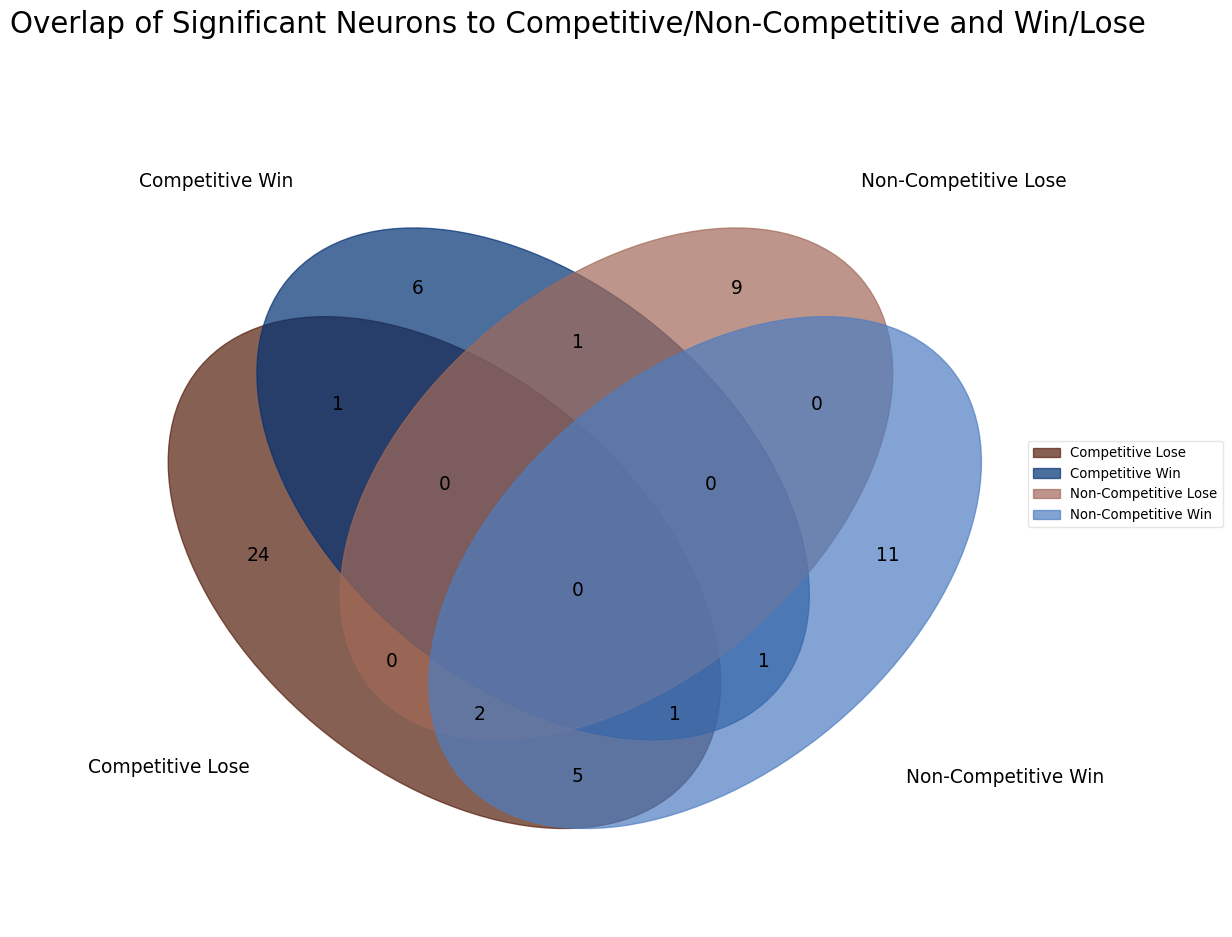

In [147]:
from matplotlib import pyplot as plt
import pyvenn

# Defining the set of events we care about with new labels
event_names = {
    'competitive_win': 'Competitive Win',
    'competitive_lose': 'Competitive Lose',
    'no_comp_win': 'Non-Competitive Win',
    'no_comp_lose': 'Non-Competitive Lose'
}

# Defining custom colors with alpha for transparency
colors = {
    'competitive_win': "#003074B3",  # Alpha 88 (hex) ≈ 0.53 (decimal)
    'no_comp_win': "#4d7dc1B3",
    'competitive_lose': "#551d0bB3",
    'no_comp_lose': "#a16958B3"
}

# Preparing data and labels for the Venn diagram
data = [event_sets[event] for event in sorted(target_events)]
labels = pyvenn.get_labels(data, fill=["number"])
names = [event_names[event] for event in sorted(target_events)]
color_values = [colors[event] for event in sorted(target_events)]

# Draw the Venn diagram using venn4
fig, ax = pyvenn.venn4(labels, names, colors=color_values)
plt.title('Overlap of Significant Neurons to Competitive/Non-Competitive and Win/Lose', fontsize=22)
plt.show()


### Tried to make a 4-Set Venn Diagram, but it looks bad and isn't useful
### Instead, I'll exclude no_comp_lose

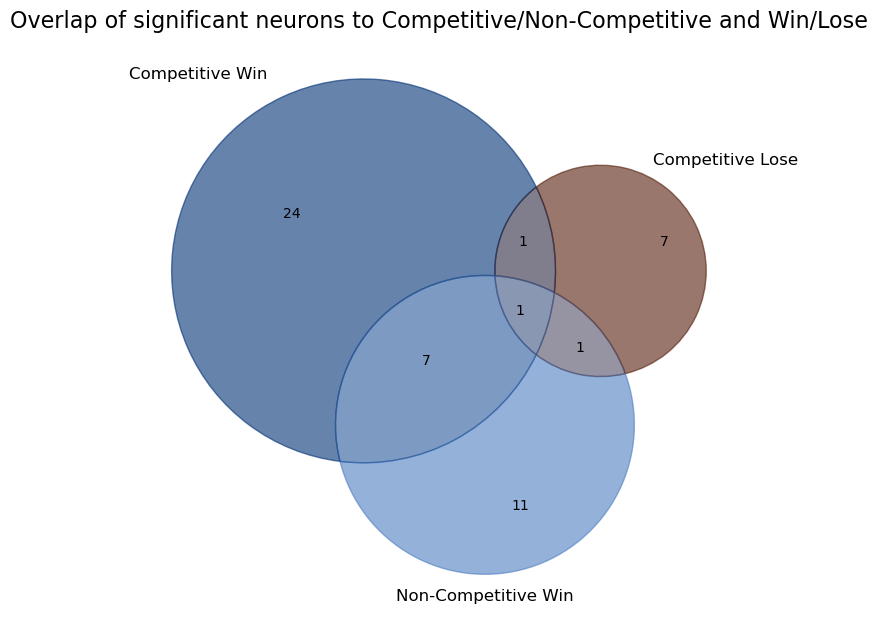

In [157]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn3_circles

# Assuming sig_units2 is your DataFrame

# Defining the set of events we care about
target_events = {'competitive_win', 'competitive_lose', 'no_comp_win'}

# Filtering and collecting events into sets
event_sets = {event: set() for event in target_events}
for index, row in sig_units2.iterrows():
    events = row['sig events']
    for event in events:
        if event in target_events:
            event_sets[event].add(index)  # using index as a unique identifier for each row

# Preparing data for the Venn diagram
sets = [event_sets[event] for event in sorted(target_events)]

# Draw the Venn diagram using venn3
plt.figure(figsize=(8, 8))
v = venn3(subsets=(sets[0], sets[1], sets[2]), set_labels=('Competitive Win', 'Competitive Lose', 'Non-Competitive Win'))

# Customizing the colors for individual and overlapping areas
# Base colors
base_colors = ['#003074', '#551d0b', '#4d7dc1']
# Apply colors with transparency
v.get_patch_by_id('100').set_color(base_colors[0])
v.get_patch_by_id('010').set_color(base_colors[1])
v.get_patch_by_id('001').set_color(base_colors[2])

# Set alpha for all
for pid in ['100', '010', '001']:
    v.get_patch_by_id(pid).set_alpha(0.6)

# Custom colors for intersections
v.get_patch_by_id('110').set_color("#2B2740")  # Overlap between Competitive Win and Competitive Lose
v.get_patch_by_id('101').set_color("#27579B")  # Overlap between Competitive Win and Non-Competitive Win
v.get_patch_by_id('011').set_color("#514D66")  # Overlap between Competitive Lose and Non-Competitive Win

# Set alpha for intersections
for pid in ['110', '101', '011']:
    v.get_patch_by_id(pid).set_alpha(0.6)

# Adjusting color for the central overlap area
v.get_patch_by_id('111').set_color("#3C5281")  # Custom color for central overlap
v.get_patch_by_id('111').set_alpha(0.6)  # Maintaining consistency with transparency

plt.title('Overlap of significant neurons to Competitive/Non-Competitive and Win/Lose', fontsize=16)
plt.show()


## Now onto the pie plot

In [183]:
sig_units

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig,putative type
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.000000,0.000000,0.200000,inf,increase,pyramidal
5,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,24,1.500000,2.511512,5.900000,1.751933,increase,pyramidal
14,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,58,0.000000,0.000000,0.200000,inf,increase,pyramidal
33,20230612_101430_standard_comp_to_training_D1_s...,competitive_win,54,0.662500,0.592555,1.975000,2.214983,increase,pyramidal
74,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,53,0.000000,0.000000,0.020000,inf,increase,pyramidal
...,...,...,...,...,...,...,...,...,...
1700,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,competitive_lose,75,0.114286,0.265197,0.885714,2.908884,increase,pyramidal
1727,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,no_comp_win,24,0.700000,1.168923,10.400000,8.298235,increase,interneuron
1735,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,0,1.150000,1.747526,5.100000,2.260339,increase,pyramidal
1738,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,24,0.650000,1.311683,5.900000,4.002491,increase,interneuron


In [195]:
sig_units = sig_units[sig_units['Event name'] != 'tie']
sig_units

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig,putative type
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.000000,0.000000,0.200000,inf,increase,pyramidal
5,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,24,1.500000,2.511512,5.900000,1.751933,increase,pyramidal
14,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,58,0.000000,0.000000,0.200000,inf,increase,pyramidal
33,20230612_101430_standard_comp_to_training_D1_s...,competitive_win,54,0.662500,0.592555,1.975000,2.214983,increase,pyramidal
74,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,53,0.000000,0.000000,0.020000,inf,increase,pyramidal
...,...,...,...,...,...,...,...,...,...
1674,20240323_144517_alone_comp_subj_3-4_t6b6_merge...,no_comp_lose,3,6.100000,5.433986,19.200000,2.410753,increase,pyramidal
1675,20240323_144517_alone_comp_subj_3-4_t6b6_merge...,no_comp_lose,4,14.100000,8.874625,32.100000,2.028255,increase,pyramidal
1676,20240323_144517_alone_comp_subj_3-4_t6b6_merge...,no_comp_lose,7,4.800000,4.977900,13.700000,1.787903,increase,pyramidal
1700,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,competitive_lose,75,0.114286,0.265197,0.885714,2.908884,increase,pyramidal


### Tie is an indeterminant outcome so can't really be considered a specific event, so removed above

In [209]:
# Calculate the proportions
sig_counts = sig_units['sig'].value_counts()
increase_counts = sig_units[sig_units['sig'] == 'increase']['putative type'].value_counts()
decrease_counts = sig_units[sig_units['sig'] == 'decrease']['putative type'].value_counts()

In [210]:
sig_counts

sig
increase    67
decrease     8
Name: count, dtype: int64

In [211]:
total_putative_count = sig_units['putative type'].value_counts()
total_putative_count

putative type
pyramidal      64
interneuron    11
Name: count, dtype: int64

In [212]:
sig_units_increase = sig_units[sig_units['sig'] == 'increase']

In [213]:
total_inc_count = sig_counts['increase']
int(total_inc_count)

67

In [214]:
total_dec_count = sig_counts['decrease']
int(total_dec_count)

8

In [215]:
total_pyr_count = total_putative_count['pyramidal']
int(total_pyr_count)

64

In [216]:
total_inter_count = total_putative_count['interneuron']
int(total_inter_count)

11

In [217]:
incr_type_count = sig_units_increase['putative type'].value_counts()

In [218]:
incr_pyr_count = incr_type_count['pyramidal']
int(incr_pyr_count)

59

In [219]:
incr_inter_count = incr_type_count['interneuron']
int(incr_inter_count)

8

In [220]:
sig_units_decrease = sig_units[sig_units['sig'] == 'decrease']

In [221]:
decr_type_count = sig_units_decrease['putative type'].value_counts()

In [222]:
decr_pyr_count = decr_type_count['pyramidal']
int(decr_pyr_count)

5

In [223]:
decr_inter_count = decr_type_count['interneuron']
int(decr_inter_count)

3

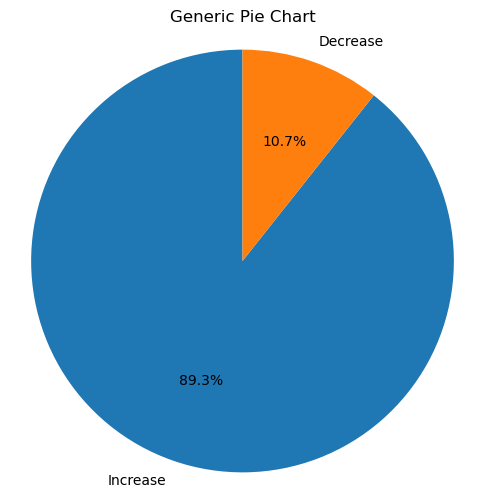

In [224]:
# Example data
data_points = [total_inc_count, total_dec_count]
labels = ['Increase', 'Decrease']

# Plot the pie chart
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(data_points, labels=labels, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

plt.title("Generic Pie Chart")
plt.show()

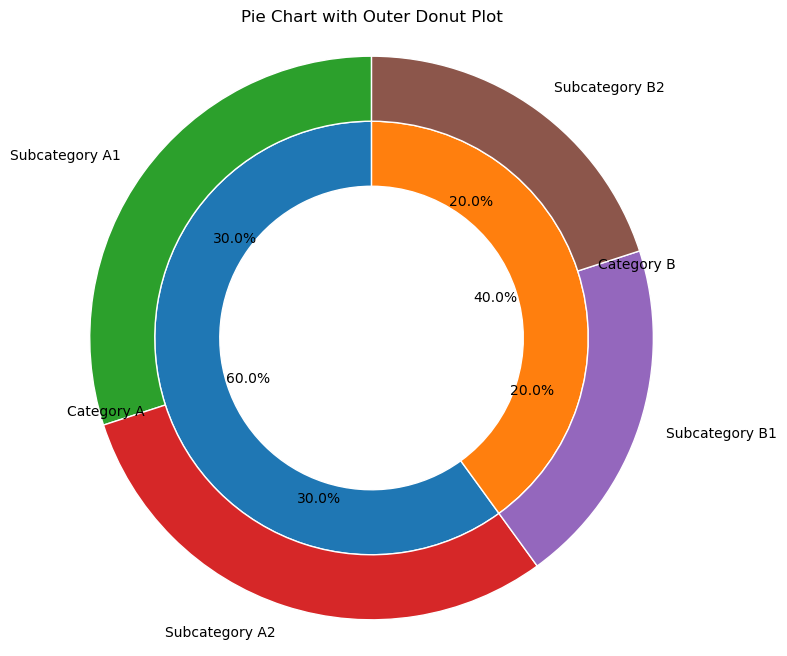

In [176]:
import matplotlib.pyplot as plt

# Example data for inner pie chart
inner_data_points = [60, 40]
inner_labels = ['Category A', 'Category B']

# Example data for outer donut plot
outer_data_points = [30, 30, 20, 20]
outer_labels = ['Subcategory A1', 'Subcategory A2', 'Subcategory B1', 'Subcategory B2']

# Plot the inner pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(inner_data_points, labels=inner_labels, autopct='%1.1f%%', startangle=90, radius=1, wedgeprops=dict(width=0.3, edgecolor='w'))

# Plot the outer donut chart
ax.pie(outer_data_points, labels=outer_labels, autopct='%1.1f%%', startangle=90, radius=1.3, wedgeprops=dict(width=0.3, edgecolor='w'))

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

plt.title("Pie Chart with Outer Donut Plot")
plt.show()

In [177]:
total_inc_count

np.int64(73)

In [178]:
total_dec_count

np.int64(8)

In [179]:
incr_pyr_count

np.int64(64)

In [180]:
incr_inter_count

np.int64(9)

In [181]:
decr_pyr_count

np.int64(5)

In [182]:
decr_inter_count

np.int64(3)

In [253]:
merged_df = merged_df[merged_df['Event name'] != 'tie']

In [254]:
# Group by 'Recording' and 'Unit number' and aggregate the required columns
grouped = merged_df.groupby(['Recording', 'Unit number']).agg({
    'Event name': lambda x: list(x),
    'sig': lambda x: list(x),
    'putative type': 'first'  # Assuming 'putative type' is consistent within each group
}).reset_index()

# Initialize lists to store the 'sig events', 'not sig events', and 'exc/inh' classification
sig_events = []
not_sig_events = []
exc_inh = []

# Iterate over the grouped DataFrame to populate the lists
for index, row in grouped.iterrows():
    sig_list = []
    not_sig_list = []
    exc = False
    inh = False

    for event_name, sig in zip(row['Event name'], row['sig']):
        if sig == 'increase':
            sig_list.append(event_name)
            exc = True
        elif sig == 'decrease':
            sig_list.append(event_name)
            inh = True
        elif sig == 'not sig':
            not_sig_list.append(event_name)

    # Determine the excitatory/inhibitory classification based on sig events
    if exc and inh:
        exc_inh.append('both')
    elif exc:
        exc_inh.append('excitatory')
    elif inh:
        exc_inh.append('inhibitory')
    else:
        exc_inh.append('nan')  # None or no 'sig events'

    sig_events.append(sig_list)
    not_sig_events.append(not_sig_list)

# Create the final DataFrame
units_df = pd.DataFrame({
    'Recording': grouped['Recording'],
    'Unit number': grouped['Unit number'],
    'sig events': sig_events,
    'not sig events': not_sig_events,
    'putative type': grouped['putative type'],
    'exc/inh': exc_inh
})

# Display the new DataFrame
units_df

,Recording,Unit number,sig events,not sig events,putative type,exc/inh
0,20230612_101430_standard_comp_to_training_D1_s...,5,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal,excitatory
1,20230612_101430_standard_comp_to_training_D1_s...,10,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,nan
2,20230612_101430_standard_comp_to_training_D1_s...,13,[],"[competitive_lose, competitive_win, no_comp_lo...",interneuron,nan
3,20230612_101430_standard_comp_to_training_D1_s...,17,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,nan
4,20230612_101430_standard_comp_to_training_D1_s...,19,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,nan
...,...,...,...,...,...,...
497,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,49,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,nan
498,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,54,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,nan
499,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,68,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,nan
500,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,75,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal,excitatory


In [255]:
units_df['exc/inh'].value_counts()

exc/inh
nan           441
excitatory     53
inhibitory      7
both            1
Name: count, dtype: int64

In [256]:
# Filter the units_df to include only rows where 'sig events' is not an empty list
sig_units2 = units_df[units_df['sig events'].apply(lambda x: len(x) > 0)].copy()
sig_units2

,Recording,Unit number,sig events,not sig events,putative type,exc/inh
0,20230612_101430_standard_comp_to_training_D1_s...,5,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal,excitatory
5,20230612_101430_standard_comp_to_training_D1_s...,24,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal,excitatory
11,20230612_101430_standard_comp_to_training_D1_s...,53,[no_comp_win],"[competitive_lose, competitive_win, no_comp_lose]",pyramidal,excitatory
12,20230612_101430_standard_comp_to_training_D1_s...,54,[competitive_win],"[competitive_lose, no_comp_lose, no_comp_win]",pyramidal,excitatory
14,20230612_101430_standard_comp_to_training_D1_s...,58,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal,excitatory
...,...,...,...,...,...,...
486,20240323_144517_alone_comp_subj_3-4_t6b6_merge...,3,[no_comp_lose],"[competitive_lose, competitive_win, no_comp_win]",pyramidal,excitatory
487,20240323_144517_alone_comp_subj_3-4_t6b6_merge...,4,"[competitive_win, no_comp_lose]","[competitive_lose, no_comp_win]",pyramidal,both
488,20240323_144517_alone_comp_subj_3-4_t6b6_merge...,7,[no_comp_lose],"[competitive_lose, competitive_win, no_comp_win]",pyramidal,excitatory
494,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,24,[no_comp_win],"[competitive_lose, competitive_win, no_comp_lose]",interneuron,excitatory


In [237]:
units_df

,Recording,Unit number,sig events,not sig events,putative type,exc/inh
0,20230612_101430_standard_comp_to_training_D1_s...,5,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal,excitatory
1,20230612_101430_standard_comp_to_training_D1_s...,10,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,Non-Responsive Units
2,20230612_101430_standard_comp_to_training_D1_s...,13,[],"[competitive_lose, competitive_win, no_comp_lo...",interneuron,Non-Responsive Units
3,20230612_101430_standard_comp_to_training_D1_s...,17,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,Non-Responsive Units
4,20230612_101430_standard_comp_to_training_D1_s...,19,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,Non-Responsive Units
...,...,...,...,...,...,...
497,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,49,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,Non-Responsive Units
498,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,54,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,Non-Responsive Units
499,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,68,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,Non-Responsive Units
500,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,75,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal,excitatory


In [243]:
vals_putative

array([404,  37,  53,   8])

In [258]:
units_df

,Recording,Unit number,sig events,not sig events,putative type,exc/inh
0,20230612_101430_standard_comp_to_training_D1_s...,5,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal,excitatory
1,20230612_101430_standard_comp_to_training_D1_s...,10,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,Non-Responsive Units
2,20230612_101430_standard_comp_to_training_D1_s...,13,[],"[competitive_lose, competitive_win, no_comp_lo...",interneuron,Non-Responsive Units
3,20230612_101430_standard_comp_to_training_D1_s...,17,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,Non-Responsive Units
4,20230612_101430_standard_comp_to_training_D1_s...,19,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,Non-Responsive Units
...,...,...,...,...,...,...
497,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,49,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,Non-Responsive Units
498,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,54,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,Non-Responsive Units
499,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,68,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,Non-Responsive Units
500,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,75,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal,excitatory


In [259]:
units_df['exc/inh'].value_counts()

exc/inh
Non-Responsive Units    441
excitatory               53
inhibitory                7
both                      1
Name: count, dtype: int64

In [262]:
responsive_df = units_df[units_df['exc/inh'] != 'Non-Responsive Units']
responsive_df['putative type'].value_counts()

putative type
pyramidal      53
interneuron     8
Name: count, dtype: int64

In [264]:
non_responsive_df = units_df[units_df['exc/inh'] == 'Non-Responsive Units']
non_responsive_df['putative type'].value_counts()

putative type
pyramidal      404
interneuron     37
Name: count, dtype: int64

In [265]:
(53+7+1)/(441+53+7+1)

0.12151394422310757

In [266]:
((441+53+7+1)-(53+7+1))/(441+53+7+1)

0.8784860557768924

In [267]:
53+7+1

61

In [268]:
(441+53+7+1)-(53+7+1)

441

In [269]:
404/(404+37)

0.9160997732426304

In [270]:
37/(404+37)

0.08390022675736962

In [271]:
53/(53+8)

0.8688524590163934

In [272]:
8/(53+8)

0.13114754098360656

In [284]:
putative_non_responsive_counts

putative type
pyramidal      404
interneuron     37
Name: count, dtype: int64

In [285]:
len(non_responsive_df)

441

In [286]:
putative_non_responsive_counts.get('pyramidal', 0) / len(non_responsive_df)

np.float64(0.9160997732426304)

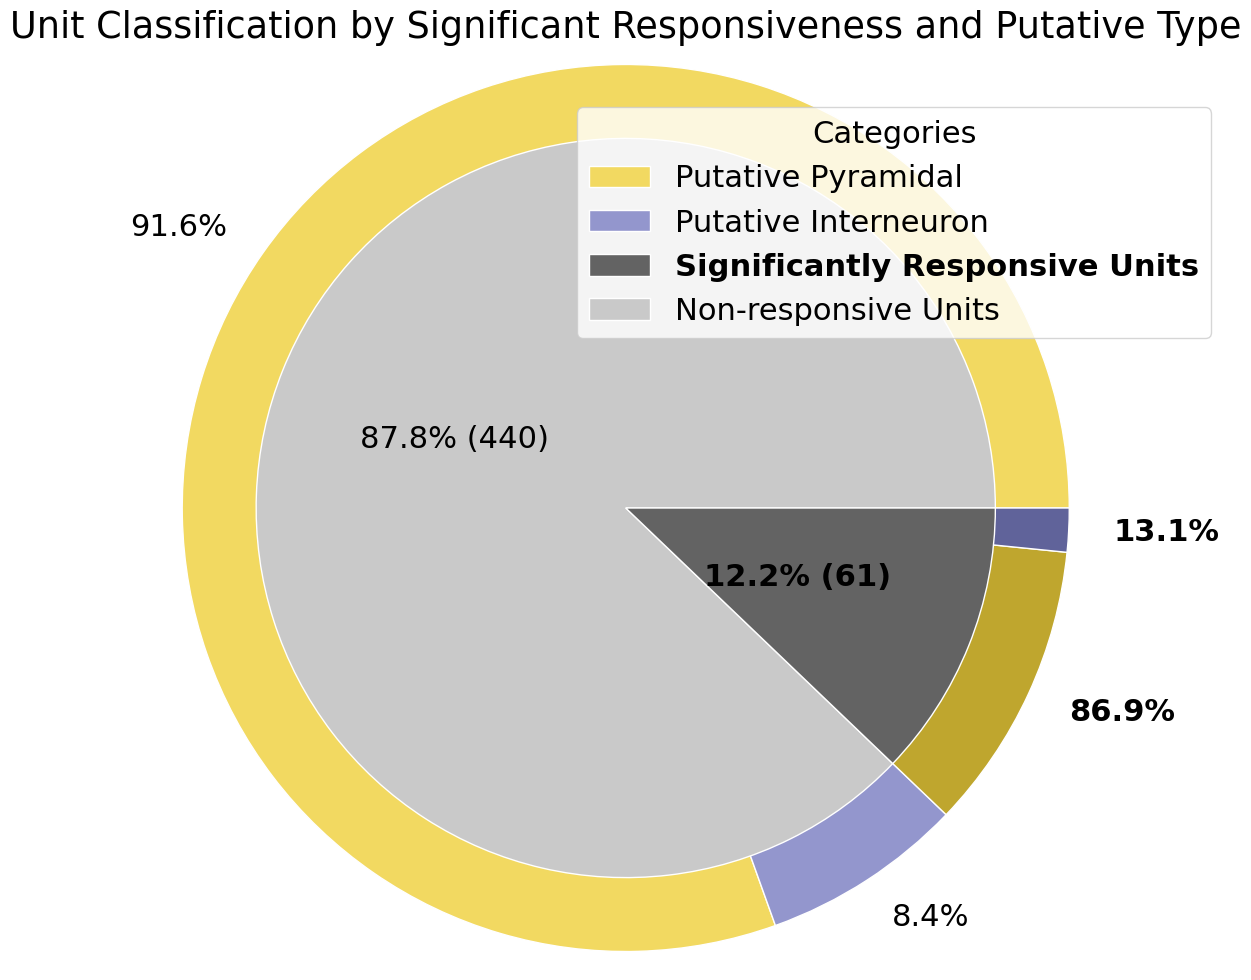

In [303]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming units_df is already loaded with your data

# Reclassifying 'exc/inh' for simplification
units_df['exc/inh'] = units_df['sig events'].apply(lambda x: 'Non-Responsive Units' if not x else 'Responsive Units')
units_df['exc/inh'] = units_df['exc/inh'].replace({'excitatory': 'Responsive Units', 'inhibitory': 'Responsive Units', 'both': 'Responsive Units'})

# Prepare data for the outer ring by putative type
responsive_df = units_df[units_df['exc/inh'] == 'Responsive Units']
non_responsive_df = units_df[units_df['exc/inh'] == 'Non-Responsive Units']

putative_responsive_counts = responsive_df['putative type'].value_counts()
putative_non_responsive_counts = non_responsive_df['putative type'].value_counts()

# Colors for the plots
colors_exc_inh = ['#c9c9c9', '#636363']  # Non-Responsive, Responsive
colors_putative = ['#f2d961', '#9396cd', '#bfa62e', '#60639a']  # Updated colors for Pyramidal and Interneuron

# Define a larger figure size to accommodate the legend and increased text size
fig, ax = plt.subplots(figsize=(14, 12))  # Increase the figure size to 14x12 inches

# Set global font size larger
plt.rcParams.update({'font.size': 22})  # Increases the base font size

# Outer ring: Putative type by exc/inh
vals_outer = [
    putative_non_responsive_counts.get('pyramidal', 0), 
    putative_non_responsive_counts.get('interneuron', 0),
    putative_responsive_counts.get('pyramidal', 0), 
    putative_responsive_counts.get('interneuron', 0)
]
percentages_outer = [
    vals_outer[0] / len(non_responsive_df) * 100 if len(non_responsive_df) > 0 else 0,
    vals_outer[1] / len(non_responsive_df) * 100 if len(non_responsive_df) > 0 else 0,
    vals_outer[2] / len(responsive_df) * 100 if len(responsive_df) > 0 else 0,
    vals_outer[3] / len(responsive_df) * 100 if len(responsive_df) > 0 else 0
]
labels_outer = [
    "{:.1f}%".format(percentages_outer[0]),
    "{:.1f}%".format(percentages_outer[1]),
    "{:.1f}%".format(percentages_outer[2]),
    "{:.1f}%".format(percentages_outer[3])
]
wedges_outer, texts_outer = ax.pie(vals_outer, radius=1.2, colors=colors_putative, labels=labels_outer,
       labeldistance=1.1, wedgeprops=dict(width=0.3, edgecolor='w'))

# Bold the appropriate texts for outer responsive units
texts_outer[2].set_fontweight('bold')  # Bold Responsive Pyramidal
texts_outer[3].set_fontweight('bold')  # Bold Responsive Interneuron

# Inner ring: exc/inh
vals_inner = [putative_non_responsive_counts.sum(), putative_responsive_counts.sum()]
wedges_inner, texts_inner, autotexts_inner = ax.pie(vals_inner, radius=1, colors=colors_exc_inh, 
       autopct=lambda pct: "{:.1f}% ({:d})".format(pct, int(pct/100.*np.sum(vals_inner))), pctdistance=0.5, wedgeprops=dict(edgecolor='w'))

# Bold the text for the responsive units in the inner plot
autotexts_inner[1].set_fontweight('bold')  # Bold the percentage and count for responsive units

ax.set(aspect="equal", title='Unit Classification by Significant Responsiveness and Putative Type')

# Adding a simplified legend
legend_labels = ['Putative Pyramidal', 'Putative Interneuron', 'Significantly Responsive Units', 'Non-responsive Units']
legend_wedges = [wedges_outer[0], wedges_outer[1], wedges_inner[1], wedges_inner[0]]

legend = ax.legend(legend_wedges, legend_labels,
          title="Categories",
          loc="upper right",
          bbox_to_anchor=(1.15, 0.95))  # Adjust the location of the legend to avoid overlapping with the title

# Bold the legend text only for "Significantly Responsive Units"
legend.get_texts()[2].set_fontweight('bold')

plt.show()


In [305]:
sig_units_exc = sig_units2[sig_units2['exc/inh'] == 'excitatory']
sig_units_inh = sig_units2[sig_units2['exc/inh'] == 'inhibitory']

In [313]:
units_df

,Recording,Unit number,sig events,not sig events,putative type,exc/inh
0,20230612_101430_standard_comp_to_training_D1_s...,5,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal,Responsive Units
1,20230612_101430_standard_comp_to_training_D1_s...,10,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,Non-Responsive Units
2,20230612_101430_standard_comp_to_training_D1_s...,13,[],"[competitive_lose, competitive_win, no_comp_lo...",interneuron,Non-Responsive Units
3,20230612_101430_standard_comp_to_training_D1_s...,17,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,Non-Responsive Units
4,20230612_101430_standard_comp_to_training_D1_s...,19,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,Non-Responsive Units
...,...,...,...,...,...,...
497,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,49,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,Non-Responsive Units
498,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,54,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,Non-Responsive Units
499,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,68,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,Non-Responsive Units
500,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,75,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal,Responsive Units


In [314]:
# Group by 'Recording' and 'Unit number' and aggregate the required columns
grouped = merged_df.groupby(['Recording', 'Unit number']).agg({
    'Event name': lambda x: list(x),
    'sig': lambda x: list(x),
    'putative type': 'first'  # Assuming 'putative type' is consistent within each group
}).reset_index()

# Initialize lists to store the 'sig events' and 'not sig events'
sig_events = []
not_sig_events = []

# Iterate over the grouped DataFrame to populate the lists
for index, row in grouped.iterrows():
    sig_list = []
    not_sig_list = []
    for event_name, sig in zip(row['Event name'], row['sig']):
        if sig != 'not sig':
            sig_list.append(event_name)
        else:
            not_sig_list.append(event_name)
    sig_events.append(sig_list)
    not_sig_events.append(not_sig_list)

# Create the final DataFrame
units_df = pd.DataFrame({
    'Recording': grouped['Recording'],
    'Unit number': grouped['Unit number'],
    'sig events': sig_events,
    'not sig events': not_sig_events,
    'putative type': grouped['putative type']
})

In [325]:
# Group by 'Recording' and 'Unit number' and aggregate the required columns
grouped = merged_df.groupby(['Recording', 'Unit number']).agg({
    'Event name': lambda x: list(x),
    'sig': lambda x: list(x),
    'putative type': 'first'  # Assuming 'putative type' is consistent within each group
}).reset_index()

# Initialize lists to store the 'sig events', 'not sig events', and 'exc/inh' classification
sig_events = []
not_sig_events = []
exc_inh = []

# Iterate over the grouped DataFrame to populate the lists
for index, row in grouped.iterrows():
    sig_list = []
    not_sig_list = []
    exc = False
    inh = False

    for event_name, sig in zip(row['Event name'], row['sig']):
        if sig == 'increase':
            sig_list.append(event_name)
            exc = True
        elif sig == 'decrease':
            sig_list.append(event_name)
            inh = True
        elif sig == 'not sig':
            not_sig_list.append(event_name)

    # Determine the excitatory/inhibitory classification based on sig events
    if exc and inh:
        exc_inh.append('both')
    elif exc:
        exc_inh.append('excitatory')
    elif inh:
        exc_inh.append('inhibitory')
    else:
        exc_inh.append('nan')  # None or no 'sig events'

    sig_events.append(sig_list)
    not_sig_events.append(not_sig_list)

# Create the final DataFrame
units_df = pd.DataFrame({
    'Recording': grouped['Recording'],
    'Unit number': grouped['Unit number'],
    'sig events': sig_events,
    'not sig events': not_sig_events,
    'putative type': grouped['putative type'],
    'exc/inh': exc_inh
})

# Display the new DataFrame
units_df

,Recording,Unit number,sig events,not sig events,putative type,exc/inh
0,20230612_101430_standard_comp_to_training_D1_s...,5,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal,excitatory
1,20230612_101430_standard_comp_to_training_D1_s...,10,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,nan
2,20230612_101430_standard_comp_to_training_D1_s...,13,[],"[competitive_lose, competitive_win, no_comp_lo...",interneuron,nan
3,20230612_101430_standard_comp_to_training_D1_s...,17,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,nan
4,20230612_101430_standard_comp_to_training_D1_s...,19,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,nan
...,...,...,...,...,...,...
497,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,49,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,nan
498,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,54,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,nan
499,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,68,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,nan
500,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,75,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal,excitatory


In [326]:
units_df

,Recording,Unit number,sig events,not sig events,putative type,exc/inh
0,20230612_101430_standard_comp_to_training_D1_s...,5,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal,excitatory
1,20230612_101430_standard_comp_to_training_D1_s...,10,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,nan
2,20230612_101430_standard_comp_to_training_D1_s...,13,[],"[competitive_lose, competitive_win, no_comp_lo...",interneuron,nan
3,20230612_101430_standard_comp_to_training_D1_s...,17,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,nan
4,20230612_101430_standard_comp_to_training_D1_s...,19,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,nan
...,...,...,...,...,...,...
497,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,49,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,nan
498,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,54,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,nan
499,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,68,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal,nan
500,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,75,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal,excitatory


In [327]:
pyramidal_df = units_df[units_df['putative type'] == 'pyramidal']
interneuron_df = units_df[units_df['putative type'] == 'interneuron']

In [328]:
pyramidal_df['sig events'].value_counts()

sig events
[]                                                  404
[competitive_lose]                                   21
[no_comp_lose]                                        9
[no_comp_win]                                         8
[competitive_win]                                     6
[competitive_lose, no_comp_win]                       5
[competitive_lose, competitive_win, no_comp_win]      1
[competitive_win, no_comp_win]                        1
[competitive_lose, no_comp_lose, no_comp_win]         1
[competitive_win, no_comp_lose]                       1
Name: count, dtype: int64

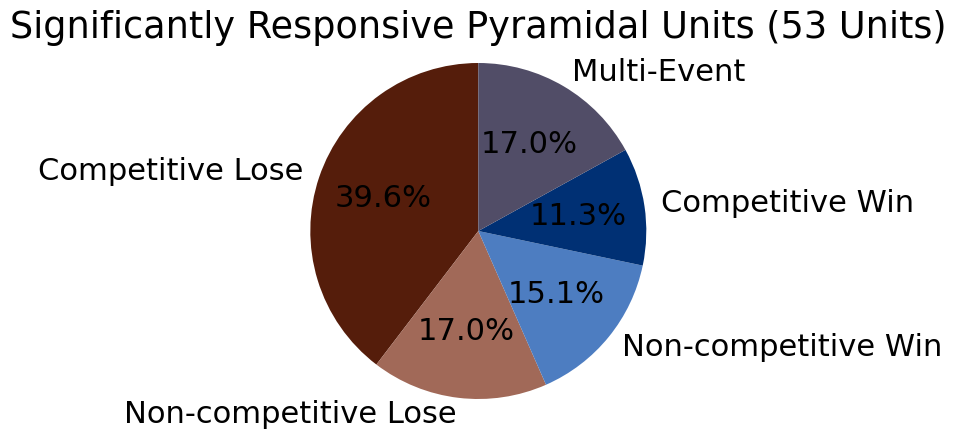

In [329]:
import matplotlib.pyplot as plt

# Data from 'sig events'
events_count = {
    '[]': 404,
    '[competitive_lose]': 21,
    '[no_comp_lose]': 9,
    '[no_comp_win]': 8,
    '[competitive_win]': 6,
    '[competitive_lose, no_comp_win]': 5,
    '[competitive_lose, competitive_win, no_comp_win]': 1,
    '[competitive_win, no_comp_win]': 1,
    '[competitive_lose, no_comp_lose, no_comp_win]': 1,
    '[competitive_win, no_comp_lose]': 1
}

# Categories and their colors
categories = {
    'Competitive Lose': {'count': events_count['[competitive_lose]'], 'color': '#551d0b'},
    'Non-competitive Lose': {'count': events_count['[no_comp_lose]'], 'color': '#a16958'},
    'Non-competitive Win': {'count': events_count['[no_comp_win]'], 'color': '#4d7dc1'},
    'Competitive Win': {'count': events_count['[competitive_win]'], 'color': '#003074'},
    'Multi-Event': {'count': sum([events_count[event] for event in events_count if event not in 
                                 ['[]', '[competitive_lose]', '[no_comp_lose]', '[no_comp_win]', '[competitive_win]']]),
                    'color': '#514D67'}
}

# Prepare data for the pie plot
labels = list(categories.keys())
sizes = [category['count'] for category in categories.values()]
colors = [category['color'] for category in categories.values()]

# Create pie plot
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title
plt.title('Significantly Responsive Pyramidal Units (53 Units)')

# Show plot
plt.show()

In [330]:
interneuron_df['sig events'].value_counts()

sig events
[]                                               37
[competitive_lose]                                3
[no_comp_win]                                     3
[competitive_lose, no_comp_lose, no_comp_win]     1
[competitive_lose, competitive_win]               1
Name: count, dtype: int64

In [331]:
interneuron_df_sig = interneuron_df[interneuron_df['sig events'].apply(lambda x: len(x) > 0 and x != [''])]
interneuron_df_sig

,Recording,Unit number,sig events,not sig events,putative type,exc/inh
214,20230618_100636_standard_comp_to_omission_D2_s...,19,"[competitive_lose, competitive_win]","[no_comp_lose, no_comp_win]",interneuron,excitatory
238,20230619_115321_standard_comp_to_omission_D3_s...,272,"[competitive_lose, no_comp_lose, no_comp_win]",[],interneuron,excitatory
278,20230621_111240_standard_comp_to_omission_D5_s...,7,[no_comp_win],"[competitive_lose, no_comp_lose]",interneuron,excitatory
286,20230621_111240_standard_comp_to_omission_D5_s...,36,[competitive_lose],"[no_comp_lose, no_comp_win]",interneuron,inhibitory
380,20230625_112913_standard_comp_to_both_rewarded...,32,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",interneuron,inhibitory
411,20240320_171038_alone_comp_subj_4-3_t5b5_merge...,13,[no_comp_win],[competitive_win],interneuron,inhibitory
473,20240323_144517_alone_comp_subj_3-1_t5b5_merge...,4,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",interneuron,excitatory
494,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,24,[no_comp_win],"[competitive_lose, competitive_win, no_comp_lose]",interneuron,excitatory


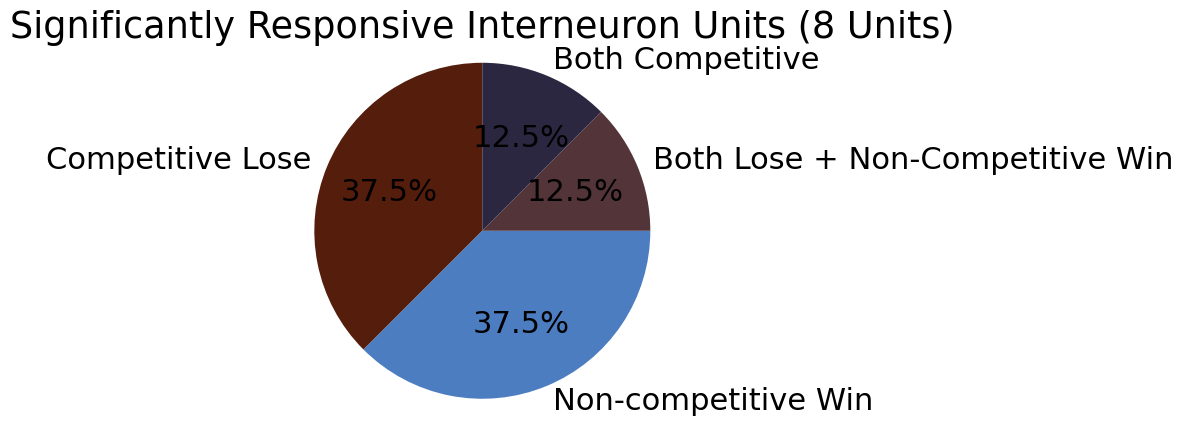

In [334]:
import matplotlib.pyplot as plt

# Provided data breakdown
events_count = {
    '[competitive_lose]': 3,
    '[no_comp_win]': 3,
    '[competitive_lose, no_comp_lose, no_comp_win]': 1,
    '[competitive_lose, competitive_win]': 1
}

# Mapping categories to colors and labels
categories = {
    'Competitive Lose': {'count': events_count['[competitive_lose]'], 'color': '#551d0b', 'label': 'Competitive Lose'},
    'Non-competitive Win': {'count': events_count['[no_comp_win]'], 'color': '#4d7dc1', 'label': 'Non-competitive Win'},
    'Both Lose + Non-Competitive Win': {'count': events_count['[competitive_lose, no_comp_lose, no_comp_win]'], 'color': '#533539', 'label': 'Both Lose + Non-Competitive Win'},
    'Both Competitive': {'count': events_count['[competitive_lose, competitive_win]'], 'color': '#2B2740', 'label': 'Both Competitive'}
}

# Prepare data for the pie plot
labels = [category['label'] for category in categories.values()]
sizes = [category['count'] for category in categories.values()]
colors = [category['color'] for category in categories.values()]

# Create pie plot
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title
plt.title('Significantly Responsive Interneuron Units (8 Units)')

# Show plot
plt.show()
